In [67]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import h5py
from matplotlib import pyplot as plt
import numpy as np
import scipy
import cv2

In [4]:
import socket
socket.gethostname()

'Paisam'

In [5]:
with open(r'data\data_filepath.txt', 'r') as file:
    pc_name, filepath = file.read().replace('\n', '').split(',')
    
    if socket.gethostname() == pc_name:
        data_filepath = filepath
    else:
        data_filepath = '101024_FluorDot_Center_Above_0p03_0000.h5'

data_filepath

'101024_FluorDot_Center_Above_0p03_0000.h5'

In [6]:
fid = h5py.File('data.h5','r')

keyf = []
for ix,k in enumerate(fid):
#         index.append(ix)
    keyf.append(k)

In [ ]:
h5file = h5py.File(data_filepath,'r')
key = []
for ix,k in enumerate(h5file):
    key.append(k)

Example of cross-correlation based tracking for a molecule inside roi

Detected molecule new position in frame2: (7, 6)


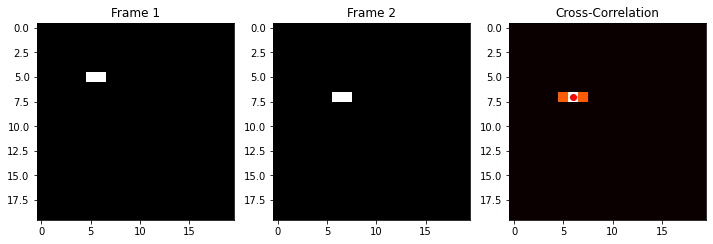

In [8]:
frame1 = np.zeros((20, 20))
frame1[5, 5] = 1  # Molecule location
frame1[5, 6] = 1  # Molecule location

frame2 = np.zeros((20, 20))
frame2[7, 6] = 1  # New molecule location
frame2[7, 7] = 1  # New molecule location

roi = frame1[4:7, 4:7]

# Perform cross-correlation to find the best match for this ROI in frame2
correlation = scipy.signal.correlate2d(frame2, roi, mode='same')

# Find the peak in the cross-correlation result, which indicates the new location
y, x = np.unravel_index(np.argmax(correlation), correlation.shape)

print("Detected molecule new position in frame2:", (y, x))

# Visualization of frames and cross-correlation result
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# Show Frame 1
ax[0].imshow(frame1, cmap='gray')
ax[0].set_title("Frame 1")

# Show Frame 2
ax[1].imshow(frame2, cmap='gray')
ax[1].set_title("Frame 2")

# Show Cross-Correlation result
ax[2].imshow(correlation, cmap='hot')
ax[2].plot(x, y, 'ro')  # Mark the detected position
ax[2].set_title("Cross-Correlation")

plt.show()


Running the cross-correlation tracking for "real data" which is an example particle moving with many noisy observations

Original Particle Location Frame 1
63 22
Moved Particle Location Frame 2
238 47
Tracked Particle Location Frame 2
238 47


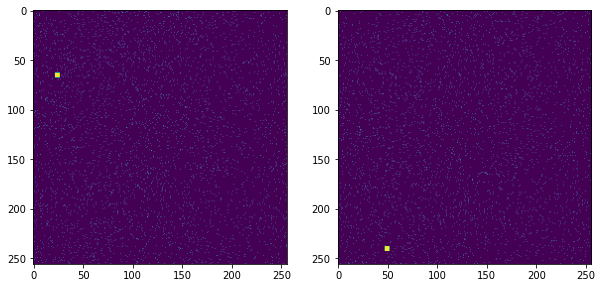

In [77]:
frame1 = h5file[key[1]][()]
rand_frame1 = np.array(frame1)[:,:,50]
frame2 = h5file[key[2]][()]
rand_frame2 = np.array(frame2)[:,:,50]


matrix_size = (256, 256)
object_size = 5
object_value = 5
object_matrix = np.full((object_size, object_size), object_value)

# Randomly select a position for the object, ensuring it fits within the matrix
x_pos1 = np.random.randint(0, matrix_size[0] - object_size)
y_pos1 = np.random.randint(0, matrix_size[1] - object_size)
x_pos2 = np.random.randint(0, matrix_size[0] - object_size)
y_pos2 = np.random.randint(0, matrix_size[1] - object_size)
# Add the object to the matrix at the random position
rand_frame1[x_pos1:x_pos1 + object_size, y_pos1:y_pos1 + object_size] = object_matrix

rand_frame2[x_pos2:x_pos2 + object_size, y_pos2:y_pos2 + object_size] = object_matrix


max_position = np.unravel_index(np.argmax(rand_frame1), rand_frame1.shape)
roi = rand_frame1[max_position[0]-5:max_position[0]+5, max_position[1]-5:max_position[1]+5]
correlation = scipy.signal.correlate2d(rand_frame2, roi, mode='same')
y, x = np.unravel_index(np.argmax(correlation), correlation.shape)
max_position2 = np.unravel_index(np.argmax(rand_frame2), rand_frame2.shape)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(rand_frame1)

plt.subplot(1, 2, 2)
plt.imshow(rand_frame2)
print("Original Particle Location Frame 1")
print(x_pos1,y_pos1)
print("Moved Particle Location Frame 2")
print(x_pos2,y_pos2)
print("Tracked Particle Location Frame 2")
print(y+1,x+1)
plt.show()

The cross-correlation above is great but it's an expensive calculation so we try a sparse estimation of corr

In [10]:
def sparse_cross_correlation(sparse_matrix1, sparse_matrix2, window_size=3):
    """
    Computes the sparse cross-correlation between two sparse matrices.
    
    :param sparse_matrix1: First sparse matrix in CSR format
    :param sparse_matrix2: Second sparse matrix in CSR format
    :param window_size: Size of the window to correlate (default 3)
    :return: Sparse cross-correlation matrix
    """
    # Ensure both matrices are in CSR format
    assert sparse_matrix1.format == 'csr' and sparse_matrix2.format == 'csr', \
        "Both matrices must be in CSR format"
    
    # Get non-zero indices and values of both matrices
    row1, col1 = sparse_matrix1.nonzero()
    row2, col2 = sparse_matrix2.nonzero()
    
    # Initialize a dictionary to store the correlation result (for sparse output)
    correlation_dict = {}

    # Loop through non-zero elements of both matrices
    for i in range(len(row1)):
        for j in range(len(row2)):
            # Compute cross-correlation for overlapping positions
            if (row1[i] == row2[j]) and (col1[i] == col2[j]):
                # Get the correlation score for this position
                correlation_score = sparse_matrix1[row1[i], col1[i]] * sparse_matrix2[row2[j], col2[j]]
                
                # Store the correlation score in the dictionary (for sparse matrix result)
                if (row1[i], col1[i]) not in correlation_dict:
                    correlation_dict[(row1[i], col1[i])] = correlation_score
                else:
                    correlation_dict[(row1[i], col1[i])] += correlation_score
    
    # Convert the result dictionary into a sparse CSR matrix
    result_rows = []
    result_cols = []
    result_values = []
    
    for (i, j), value in correlation_dict.items():
        result_rows.append(i)
        result_cols.append(j)
        result_values.append(value)
    
    # Create the sparse result matrix
    sparse_result = scipy.sparse.csr_matrix((result_values, (result_rows, result_cols)), 
                                            shape=sparse_matrix1.shape)
    
    return sparse_result


# Example usage:

# Create sparse matrices (CSR format)
data1 = np.array([1, 2, 3, 4])
row1 = np.array([0, 0, 1, 2])
col1 = np.array([0, 2, 1, 2])

data2 = np.array([4, 5, 6, 7])
row2 = np.array([0, 1, 2, 3])
col2 = np.array([0, 1, 2, 3])

# sparse_matrix1 = scipy.sparse.csr_matrix((data1, (row1, col1)), shape=(3, 3))
# sparse_matrix2 = scipy.sparse.csr_matrix((data2, (row2, col2)), shape=(3, 3))

# Perform custom sparse cross-correlation
sparse_corr_result = sparse_cross_correlation(A, B).max()

# Print result
print("Sparse Cross-Correlation Result:")
print(sparse_corr_result)


[[ 1.         -0.18898224  0.32732684]
 [-0.18898224  1.          0.8660254 ]
 [ 0.32732684  0.8660254   1.        ]]
  (2, 0)	3.6005951888938736
  (1, 0)	2.078804601550749
  (0, 0)	1.8571428571428568
  (2, 1)	9.526279441628823
  (1, 1)	6.999999999999998
  (0, 1)	2.078804601550749
  (2, 2)	13.499999999999996
  (1, 2)	9.526279441628823
  (0, 2)	3.6005951888938736


Temporal cross-corr lagtime = j regular NON SPARSE

CPU times: total: 24 s
Wall time: 46.6 s


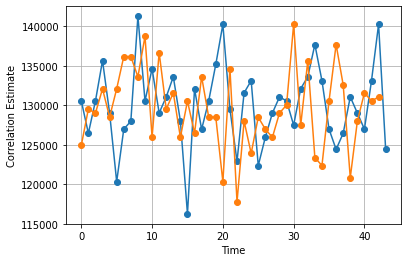

In [13]:
%%time
for j in range(2):
    count = []
    for i in range(45-j-1):
        frame1 = h5file[key[i]][()]
        frame1 = np.array(frame1)[:,:,50]

        frame2 = h5file[key[i+j+1]][()]
        frame2 = np.array(frame2)[:,:,50]
        stationary = np.argmax(scipy.signal.correlate(frame1, frame2))
        count.append([i,stationary])
    count = np.array(count)
    x = count[:, 0]
    y = count[:, 1]
    plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Correlation Estimate')
plt.grid(True)

First version of sparse temporal cross-corr does not work (homogenous data)

CPU times: total: 4min 8s
Wall time: 7min 33s


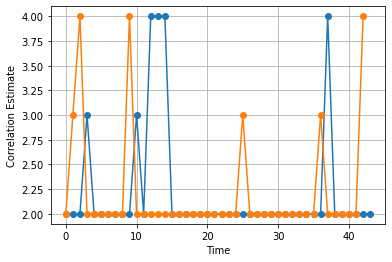

In [14]:
%%time
for j in range(2):
    count = []
    for i in range(45-j-1):
        frame1 = h5file[key[i]][()]
        frame1 = np.array(frame1)[:,:,50]
        sparse_image1 = scipy.sparse.csr_matrix(frame1)
        
        frame2 = h5file[key[i+j+1]][()]
        frame2 = np.array(frame2)[:,:,50]
        sparse_image2 = scipy.sparse.csr_matrix(frame2)
        
        stationary = sparse_cross_correlation(sparse_image1, sparse_image2).max()
        count.append([i,stationary])
    count = np.array(count)
    x = count[:, 0]
    y = count[:, 1]
    plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Correlation Estimate')
plt.grid(True)

First version of sparse temporal cross-corr does not work (cell data)

CPU times: total: 27.5 s
Wall time: 46.5 s


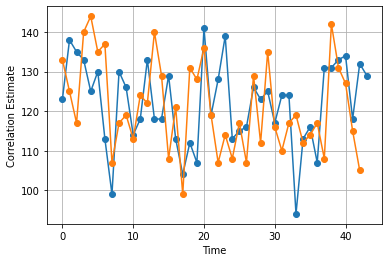

In [15]:
%%time
for j in range(2):
    count = []
    for i in range(45-j-1):
        frame1 = fid[keyf[i]][()]
        frame1 = np.array(frame1)[:,:,50]
        sparse_image1 = scipy.sparse.csr_matrix(frame1)

        frame2 = fid[keyf[i+j+1]][()]
        frame2 = np.array(frame2)[:,:,50]
        sparse_image2 = scipy.sparse.csr_matrix(frame2)
        stationary = sparse_image1.multiply(sparse_image2)
        if stationary.nnz !=0:
            count.append([i,stationary.size])
    count = np.array(count)
    x = count[:, 0]
    y = count[:, 1]
    plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Correlation Estimate')
plt.grid(True)

Stationary points locator with sparse matrices for the "real data" 

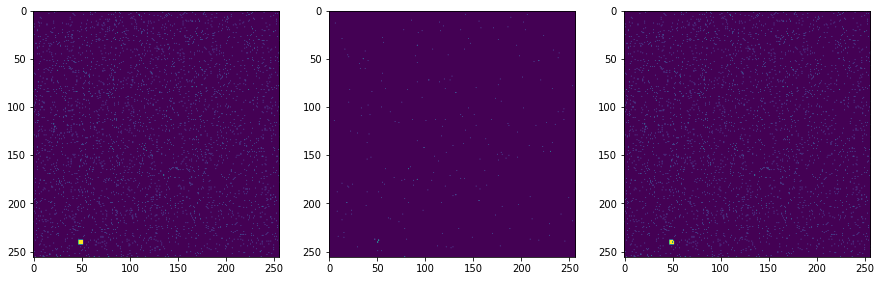

In [78]:
sparse1 = scipy.sparse.csr_matrix(rand_frame1)
sparse2 = scipy.sparse.csr_matrix(rand_frame2)
stationary = np.array(sparse1.multiply(sparse2).toarray())

# frame 2
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(rand_frame2)

#stationary points between frame 1 and 2
plt.subplot(1, 3, 2)
plt.imshow(stationary)

#removed stationary points from frame2 maybe this is one use if we only want to see moving particles
plt.subplot(1, 3, 3)
diff = cv2.subtract(rand_frame2, stationary)
plt.imshow(diff)

Frame by frame stationary point detection lagtime = j

CPU times: total: 24.3 s
Wall time: 44.4 s


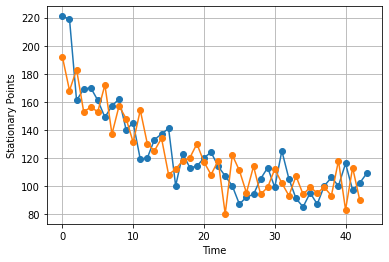

In [74]:
%%time
for j in range(2):
    count = []
    for i in range(45-j-1):
        frame1 = h5file[key[i]][()]

        frame1 = np.array(frame1)[:,:,50]
        sparse_image1 = scipy.sparse.csr_matrix(frame1)

        frame2 = h5file[key[i+j+1]][()]
        frame2 = np.array(frame2)[:,:,50]
        sparse_image2 = scipy.sparse.csr_matrix(frame2)
        stationary = sparse_image1.multiply(sparse_image2)
        if stationary.nnz !=0:
            count.append([i,stationary.size])
    count = np.array(count)
    x = count[:, 0]
    y = count[:, 1]
    plt.plot(x, y, marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Stationary Points')
plt.grid(True)


Sparse tracking idea I had which found the shape of an object in the sparse version of frame one and then only tried to match that shape with the information in sparse frame 2 WORK IN PROGRESS

In [16]:

def extract_shape_coordinates(sparse_matrix):
    """Extract the coordinates of non-zero elements as the shape template."""
    return np.array(sparse_matrix.nonzero()).T

def match_shape(template_coords, target_sparse, threshold=1.0):
    """
    Match a shape represented by template_coords in the target_sparse matrix.
    - template_coords: Non-zero coordinates of the shape.
    - target_sparse: Target sparse matrix for matching.
    - threshold: Minimum fraction of matching points for a valid match.
    """
    target_coords = np.array(target_sparse.nonzero()).T
    shape_matches = []

    for t_row, t_col in target_coords:
        # Compute offsets for the template relative to this point
        offsets = template_coords - template_coords[0]  # Normalize template
        shifted_coords = offsets + np.array([t_row, t_col])

        # Check how many of the shifted template points exist in the target
        match_count = sum(
            1 for coord in shifted_coords if tuple(coord) in map(tuple, target_coords)
        )
        match_fraction = match_count / len(template_coords)

        if match_fraction >= threshold:
            shape_matches.append((t_row, t_col))

    return shape_matches
# Define a dense matrix with a shape
matrix1 = np.array([
    [0, 0, 0, 0],
    [0, 1, 1, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 0]
])

# Target matrix with the same shape at a different location
matrix2 = np.array([
    [0, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 1, 1, 0],
    [0, 1, 1, 0]
])

# Convert to sparse
sparse1 = scipy.sparse.csr_matrix(frame1)
sparse2 = scipy.sparse.csr_matrix(frame2)

# Extract shape from matrix1
template_coords = extract_shape_coordinates(sparse1)

# Match shape in matrix2
matches = match_shape(template_coords, sparse2, threshold=1.0)

print("Template Coordinates:", template_coords)
print("Matches Found:", matches)


KeyboardInterrupt: 